In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A simple quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

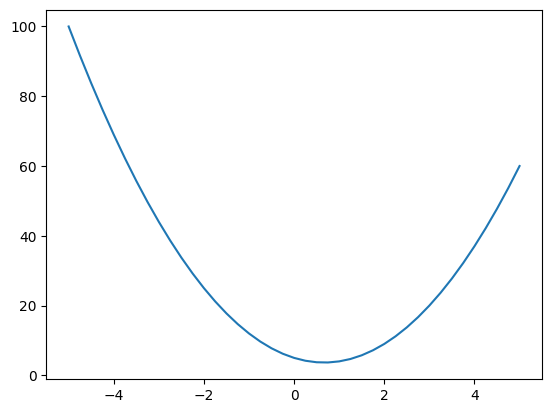

In [3]:
xs = np.arange(-5.0, 5.25, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
class Value:
    def __init__(self, data, _children=(), _operations=''):
        self.data = data
        self._prev = set(_children)
        self._operations = _operations
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, val):
        return Value(self.data + val.data, (self, val), '+')

    def __mul__(self, val):
        return Value(self.data * val.data, (self, val), '*')


In [5]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a * b + c
d._prev, d._operations

({Value(data=-6.0), Value(data=10.0)}, '+')

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f }" % (n.data,), shape='record')
    if n._operations:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operations, label = n._operations)
      # and connect this node to it
      dot.edge(uid + n._operations, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operations)

  return dot

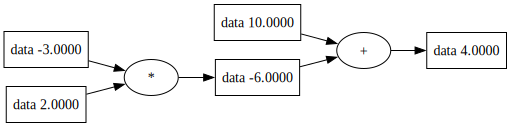

In [8]:
draw_dot(d)